In [2]:
! pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 1.2 MB/s eta 0:00:0000:0100:01m


In [4]:
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime

meta = pd.read_excel('SEWAA-data.xlsx',sheet_name='Gridded',index_col=0,nrows=2)
data = pd.read_excel('SEWAA-data.xlsx',sheet_name='Gridded',index_col=0,skiprows=[1,2])

ds = data.to_xarray().rename({'ID':'time'})

# Not sure if this is the best way but it works
ds['time'] = np.array([t[:4]+'-'+t[4:6]+'-'+t[-2:] for t in ds['time'].values.astype(str)],dtype='datetime64[ns]')

#ds = ds.assign_coords({'latitude':meta.values[0],'longitude':meta.values[1]})

#ds


In [9]:
ds

<xarray.Dataset> Size: 123kB
Dimensions:    (time: 2191)
Coordinates:
  * time       (time) datetime64[ns] 18kB 2018-01-01 2018-01-02 ... 2023-12-31
Data variables:
    KABETE     (time) float64 18kB 0.607 0.385 13.36 4.398 ... 0.0 0.857 0.0
    EASTLEIGH  (time) float64 18kB 4.32 6.645 18.03 5.776 ... 0.0 5.533 0.892
    J.K.I.A.   (time) float64 18kB 4.732 3.367 20.05 1.417 ... 0.0 5.381 2.31
    DAGORETTI  (time) float64 18kB 1.488 3.038 6.752 5.673 ... 0.0 0.039 0.912
    NGONG      (time) float64 18kB 2.332 4.642 10.11 7.531 ... 0.0 0.367 0.0
    WILSON     (time) float64 18kB 1.697 2.478 13.23 3.4 ... 0.0 0.0 0.0 0.507

In [10]:
[var for var in ds.data_vars]

['KABETE', 'EASTLEIGH', 'J.K.I.A.', 'DAGORETTI', 'NGONG', 'WILSON']

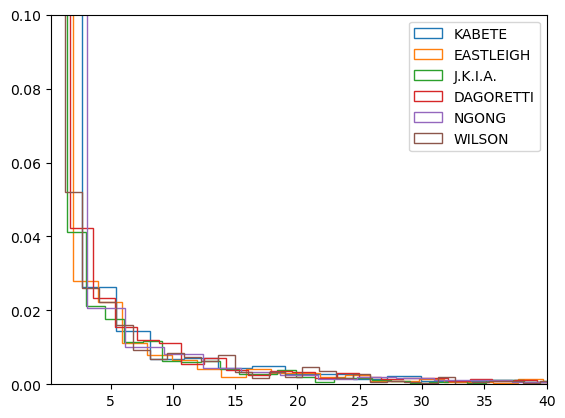

In [14]:
import matplotlib.pyplot as plt

for region in ds.data_vars:

    plt.hist(ds[region].values,bins=50,density=True,histtype='step',label=region)
    plt.xlim(0.2,40)
    plt.ylim(0,0.1)
    
plt.legend()



# Load in IMERG, cGAN and IFS

In [5]:
import glob

files = glob.glob('datasets/IMERG*_Nairobi.zarr')
ds_IMERG = xr.open_mfdataset(files,engine="zarr")

files = glob.glob('datasets/cGAN_50*_Nairobi.zarr')
ds_cGAN = xr.open_mfdataset(files,engine="zarr")

files = glob.glob('datasets/IFS*_Nairobi.zarr')
ds_IFS = []
for file in files:
    ds_IFS.append(xr.open_zarr(file).drop_duplicates('time',keep='last'))

ds_IFS = xr.concat(ds_IFS,'time')
                


In [88]:
ds_cGAN

<xarray.Dataset> Size: 1MB
Dimensions:    (time: 1234, member: 50, latlon: 6)
Coordinates:
    latitude   (latlon) float64 48B dask.array<chunksize=(6,), meta=np.ndarray>
  * latlon     (latlon) int64 48B 0 1 2 3 4 5
    longitude  (latlon) float64 48B dask.array<chunksize=(6,), meta=np.ndarray>
  * member     (member) int32 200B 1 2 3 4 5 6 7 8 9 ... 43 44 45 46 47 48 49 50
  * time       (time) datetime64[ns] 10kB 2018-01-01 2018-01-02 ... 2024-05-29
Data variables:
    Nairobi    (time, member, latlon) float32 1MB dask.array<chunksize=(29, 50, 6), meta=np.ndarray>

In [6]:
latitude_IMERG = ds_IMERG.latitude.values
longitude_IMERG = ds_IMERG.longitude.values

box_left = longitude_IMERG-0.05
box_right = longitude_IMERG+0.05
box_down = latitude_IMERG-0.05
box_up = latitude_IMERG+0.05


In [7]:
def bounding_box(region,points,min_x=box_left,max_x=box_right,min_y=box_down,max_y=box_up):

    """
    points: latitude, longitude
    x: longitude
    y: latitude
    """

    section_x = []
    section_y = []
    
    for x_min, x_max in zip(box_left,box_right):
        if region == 'J.K.I.A.':
            section_x.append(np.logical_and(points[1]<=x_max+0.01,points[1]>=x_min-0.01))
        else:
            section_x.append(np.logical_and(points[1]<=x_max,points[1]>=x_min))
            
    for y_min, y_max in zip(box_down,box_up):    
        section_y.append(np.logical_and(points[0]<=y_max,points[0]>=y_min))

    idx = np.squeeze(np.argwhere(np.logical_and(np.array(section_x),np.array(section_y))))

    return idx

idx_chosen = bounding_box('KABETE',meta['KABETE'].values,min_x=box_left,max_x=box_right,min_y=box_down,max_y=box_up)


In [8]:
meta.columns

Index(['KABETE', 'EASTLEIGH', 'J.K.I.A.', 'DAGORETTI', 'NGONG', 'WILSON'], dtype='object')

In [22]:
meta

,KABETE,EASTLEIGH,J.K.I.A.,DAGORETTI,NGONG,WILSON
ID,,,,,,
LON,36.73,36.86,36.91,36.75,36.65,36.81
DATE/LAT,-1.25,-1.26,-1.31,-1.30,-1.34,-1.31


# Visualisation with histograms

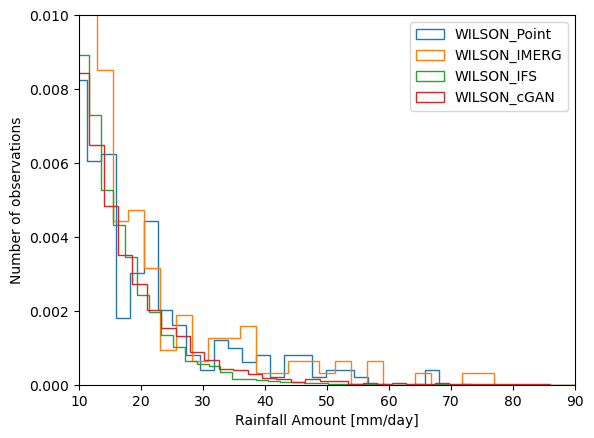

In [17]:
import matplotlib.pyplot as plt
region = 'WILSON'

idx_region =  bounding_box(region,meta[region].values,min_x=box_left,max_x=box_right,min_y=box_down,max_y=box_up)

plt.hist(ds[region].values,bins=30,density=True,histtype='step',label=region+'_Point')
plt.hist(ds_IMERG.isel({'latlon':idx_region}).Nairobi.values,bins=30,density=True,histtype='step',label=region+'_IMERG')
plt.hist(ds_IFS.isel({'latlon':idx_region}).Nairobi.values.flatten(),bins=50,density=True,histtype='step',label=region+'_IFS')
plt.hist(ds_cGAN.isel({'latlon':idx_region}).Nairobi.values.flatten(),bins=50,density=True,histtype='step',label=region+'_cGAN')
plt.xlim(10,90)
plt.ylim(0,0.01)

plt.xlabel("Rainfall Amount [mm/day]")
plt.ylabel("Number of observations")

plt.legend()


In [69]:
idx_region

array([0, 1])